# How to use Decima

In [1]:
import numpy as np
import pandas as pd
import anndata
import torch
import os, sys

# Import Decima functions
sys.path.append('../src/')

%matplotlib inline

## Load the model checkpoint and data

In [2]:
#!wget https://zenodo.org/records/15092691/files/rep0.ckpt # Model replicate 0 - change the number to get replicates 1-3
#!wget https://zenodo.org/records/15092691/files/Supplementary_file_1.h5ad # Metadata and predictions

In [2]:
matrix_file='Supplementary_file_1.h5ad'
model_file = 'rep0.ckpt'

## How to find predictions for a gene of interest

`matrix_file` contains the pseudobulk metadata in `.obs`, the gene metadata in `.var`, along with Decima's predictions for each gene and pseudobulk in `.layers['preds']`. Note that the predictions in this file are the average over four replicate models.

In [3]:
ad = anndata.read_h5ad(matrix_file)

In [4]:
ad

AnnData object with n_obs × n_vars = 8856 × 18457
    obs: 'cell_type', 'tissue', 'organ', 'disease', 'study', 'dataset', 'region', 'subregion', 'celltype_coarse', 'n_cells', 'total_counts', 'n_genes', 'size_factor', 'train_pearson', 'val_pearson', 'test_pearson'
    var: 'chrom', 'start', 'end', 'strand', 'gene_type', 'frac_nan', 'mean_counts', 'n_tracks', 'gene_start', 'gene_end', 'gene_length', 'gene_mask_start', 'gene_mask_end', 'frac_N', 'fold', 'dataset', 'gene_id', 'pearson', 'size_factor_pearson'
    uns: 'log1p'
    layers: 'preds'

In [5]:
ad.obs.head()

,cell_type,tissue,organ,disease,study,dataset,region,subregion,celltype_coarse,n_cells,total_counts,n_genes,size_factor,train_pearson,val_pearson,test_pearson
agg_0,Amygdala excitatory,Amygdala_Amygdala,CNS,healthy,jhpce#tran2021,brain_atlas,Amygdala,Amygdala,NaN,331,15928830.0,17000,41431.465186,0.942474,0.841879,0.865579
agg_1,Amygdala excitatory,Amygdala_Basolateral nuclear group (BLN) - lat...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Basolateral nuclear group (BLN) - lateral nucl...,NaN,11369,295213300.0,18080,40765.341481,0.943247,0.839565,0.860787
agg_2,Amygdala excitatory,Amygdala_Bed nucleus of stria terminalis and n...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Bed nucleus of stria terminalis and nearby - BNST,NaN,139,2593231.0,15418,42556.387020,0.952271,0.855175,0.866643
agg_3,Amygdala excitatory,Amygdala_Central nuclear group - CEN,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Central nuclear group - CEN,NaN,3892,99463712.0,17959,42884.641430,0.959857,0.863817,0.881534
agg_4,Amygdala excitatory,Amygdala_Corticomedial nuclear group (CMN) - a...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Corticomedial nuclear group (CMN) - anterior c...,NaN,2945,128161939.0,17885,41816.741933,0.951541,0.855172,0.868277


In [6]:
ad.var.head()

,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,gene_end,gene_length,gene_mask_start,gene_mask_end,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson
STRADA,chr17,63381538,63905826,-,protein_coding,0.000000,2.208074,7616,63682336,63741986,59650,163840,223490,0.0,['fold1'],train,ENSG00000266173,0.492455,0.476627
ETV4,chr17,43219172,43743460,-,protein_coding,0.030873,0.925863,5004,43527844,43579620,51776,163840,215616,0.0,['fold1'],train,ENSG00000175832,0.737548,0.613281
USP25,chr21,15566185,16090473,+,protein_coding,0.000000,3.650355,8604,15730025,15880069,150044,163840,313884,0.0,['fold6'],train,ENSG00000155313,0.905298,0.784446
ZSWIM5,chr1,44945761,45470049,-,protein_coding,0.000620,2.190115,6123,45016399,45306209,289810,163840,453650,0.0,['fold5'],train,ENSG00000162415,0.961775,0.795131
C21orf58,chr21,45963427,46487715,-,protein_coding,0.000791,1.650467,7354,46300181,46323875,23694,163840,187534,0.0,['fold6'],train,ENSG00000160298,0.645260,0.412368


In [7]:
ad.layers['preds'][:5, :5]

array([[3.0019245, 1.7627305, 4.5927725, 5.0999455, 1.7748047],
       [3.0033526, 1.7826542, 4.7232265, 5.5104795, 1.6668196],
       [2.9788709, 2.0896676, 4.8655367, 5.617505 , 1.7732594],
       [3.074754 , 2.0385346, 4.884157 , 5.273578 , 1.7600096],
       [3.1038399, 1.9592154, 4.5908647, 5.2569623, 1.7552438]],
      dtype=float32)

To find predictions for a specific gene (SPI1):

In [8]:
ad.var.loc[['SPI1']]

,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,gene_end,gene_length,gene_mask_start,gene_mask_end,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson
SPI1,chr11,47018128,47542416,-,protein_coding,0.000128,2.187062,7290,47354860,47378576,23716,163840,187556,0.0,['fold3'],test,ENSG00000066336,0.846099,-0.15956


In [9]:
np.array(ad[:, 'SPI1'].layers['preds']).squeeze()

array([0.2351853 , 0.20646904, 0.15287355, ..., 0.33639783, 0.1378721 ,
       0.20061433], dtype=float32)

You can analyze the model's predictions and performance based on the anndata object. The sections below show how to load the Decima model and perform inference to generate your own predictions.

## How to load the model checkpoint

In [10]:
from decima.lightning import LightningModel
model = LightningModel.load_from_checkpoint(model_file)
model = model.eval()

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start

## How to create sequence input for Decima given a gene of interest

Let's take another look at the featurization of the `SPI1` gene in Decima. There are 6 relevant columns:

In [20]:
ad.var.loc[['SPI1'], ['chrom', 'start', 'end', 'strand', 'gene_mask_start', 'gene_mask_end']]

,chrom,start,end,strand,gene_mask_start,gene_mask_end
SPI1,chr11,47018128,47542416,-,163840,187556


Thus, in order to predict expression for `SPI1`, Decima needs as input the sequence from 47018128-47542416 on chr11. This is a sequence of length 524288. Since the strand is `-`, the sequence must be reverse complemented. Finally, Decima needs a gene mask which indicates the boundaries of the gene. It is 0 for positions outside the gene and 1 for positions inside. `gene_mask_start` and `gene_mask_end` contain the positions of the gene boundaries on the input.

Here is how we create the sequence and the mask:

In [11]:
from decima.preprocess import make_inputs

In [15]:
spi1_seq, spi1_mask = make_inputs('SPI1', ad)

One-hot encoding sequence
Making gene mask


In [16]:
spi1_seq.shape, spi1_mask.shape

(torch.Size([4, 524288]), torch.Size([1, 524288]))

We can combine these two into a single tensor to form the model's input:

In [17]:
spi1_input = torch.vstack([spi1_seq, spi1_mask])
spi1_input.shape

torch.Size([5, 524288])

In [18]:
spi1_input[:, :10]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## How to make predictions

In [22]:
preds = model(spi1_input.to(model.device))

In [23]:
preds.shape

torch.Size([1, 8856, 1])

This returns a vector of 8,856 values corresponding to the tasks in `ad.obs`.

## How to interpret the model's predictions

To interpret the model's predictions with respect to cell type specificity, we define a set of 'on_tasks' and 'off_tasks' (background tasks).

In [24]:
spi1_cell_types = ['classical monocyte', 'intermediate monocyte', 'non-classical monocyte', 
                 'alveolar macrophage', 'macrophage']

In [25]:
on_tasks = ad.obs.index[ad.obs.cell_type.isin(spi1_cell_types)].tolist()
off_tasks = ad.obs.index[(~ad.obs.cell_type.isin(spi1_cell_types)) & (ad.obs.organ=="blood")].tolist()

len(on_tasks), len(off_tasks)

(640, 750)

In [26]:
from decima.interpret import attributions, find_attr_peaks, scan_attributions

attr, tss_pos =  attributions(
    gene="SPI1", inputs=spi1_input, model=model, device=0, 
    tasks=on_tasks,
    off_tasks=off_tasks,
    transform="specificity")

/opt/conda/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Note that if we only want to interpret the model's predictions for some set of tasks without caring about specificity, we should use `transform="aggregate" and not define `off_tasks`.

In [27]:
attr.shape

(4, 524288)

In addition to the attributions, this function also returns the position of the TSS on the input. This is normally 163840 but this is not the case for all genes.

In [28]:
tss_pos

163840

First, we can visualize the importance across the entire 500 kb interval:

In [29]:
from decima.visualize import plot_attribution_peaks

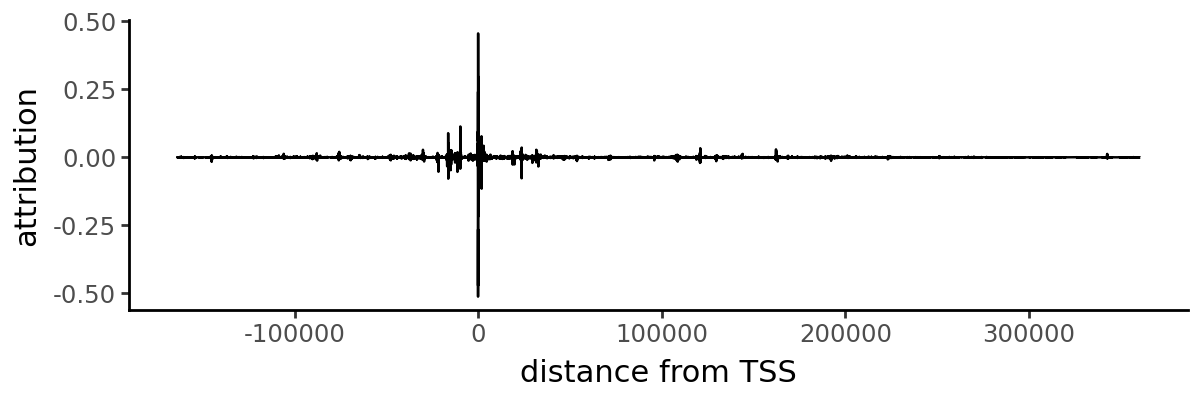

In [30]:
plot_attribution_peaks(attr, tss_pos)

We can also identify the peaks or regions of high importance:

In [31]:
peaks = find_attr_peaks(attr, tss_pos=tss_pos, n=10, min_dist=6)
peaks

,peak,height,from_tss
0,163795,1.823763,-45
1,163878,1.186533,38
2,163771,0.965062,-69
3,163785,0.885444,-55
4,163810,0.800556,-30
5,163886,0.722986,46
6,163870,0.691064,30
7,163898,0.611057,58
8,163849,0.599899,9
9,164109,0.594444,269


We will visualize the attributions close to the TSS (which contains the top two peaks:

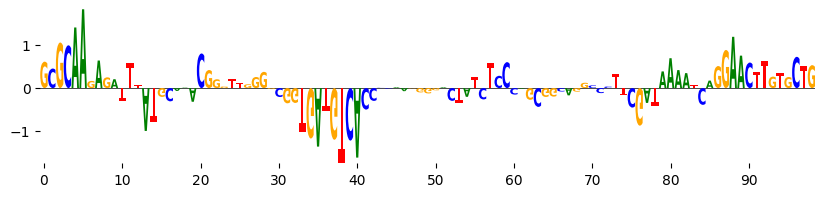

In [32]:
from grelu.visualize import plot_attributions
plot_attributions(attr[:, tss_pos-50:tss_pos+50], figsize=(10, 2))

We can also match these top 2 peaks to motifs:

In [33]:
results = decima.interpret.scan_attributions(
    seq=spi1_seq, attr=attr, motifs='hocomoco_v12', peaks=peaks.iloc[:2], window=18, pthresh=5e-4)

/opt/conda/lib/python3.11/site-packages/tangermeme/tools/fimo.py:391: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/opt/conda/lib/python3.11/site-packages/tangermeme/tools/fimo.py:391: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [34]:
results.sort_values('p-value').groupby('peak').head(3)

,motif,sequence,seq_idx,start,end,strand,score,p-value,matched_seq,site_attr_score,motif_attr_score,peak,height,from_tss
12,SPIB.H12CORE.1.S.C,1,1,1,14,+,10.095720,0.000022,AAATCAGGAACTT,0.119940,0.396839,163878,1.186533,38
5,EHF.H12CORE.0.P.B,1,1,1,16,+,9.409240,0.000136,AAATCAGGAACTTGT,0.114074,0.299387,163878,1.186533,38
11,SPI1.H12CORE.0.P.B,1,1,1,15,+,7.670585,0.000147,AAATCAGGAACTTG,0.116095,0.339366,163878,1.186533,38
3,CEBPG.H12CORE.1.SM.B,0,0,0,12,-,7.931759,0.000198,TGTAGCGCAAGA,0.165716,0.589583,163795,1.823763,-45
4,KAISO.H12CORE.0.P.B,0,0,2,13,+,8.282666,0.000324,TAGCGCAAGAG,0.162170,0.444266,163795,1.823763,-45
0,CEBPA.H12CORE.0.P.B,0,0,0,12,+,7.964049,0.000345,TGTAGCGCAAGA,0.165716,0.577324,163795,1.823763,-45


## How to predict variant impact

To predict variant impact, Decima requires a dataframe containing variant columns (chrom, pos, ref, alt), as well as the gene name. Optionally, the cell type of interest can also be included.

We will use a few fine-mapped eQTLs in this example.

In [35]:
variant_df = pd.read_table("variants.tsv")
variant_df

,chrom,pos,ref,alt,gene,rsid
0,chr1,1000018,G,A,ISG15,rs146254088
1,chr1,1002308,T,C,ISG15,rs2489000
2,chr1,109727471,A,C,GSTM3,rs11101994
3,chr1,109728286,T,G,GSTM3,rs4540683
4,chr1,109728807,T,G,GSTM3,rs4970775


We first need to ensure that these variants are close enough to a gene.

In [38]:
from decima.variant import process_variants

In [39]:
variant_df = process_variants(variant_df, ad, min_from_end=5000)
variant_df

dropped 0 variants because the gene was not found in ad.var
dropped 0 variants because the variant did not fit in the interval


,chrom,pos,ref,alt,gene,rsid,start,end,strand,gene_mask_start,rel_pos,ref_tx,alt_tx,tss_dist
0,chr1,1000018,G,A,ISG15,rs146254088,837298,1361586,+,163840,162720,G,A,-1120
1,chr1,1002308,T,C,ISG15,rs2489000,837298,1361586,+,163840,165010,T,C,1170
2,chr1,109727471,A,C,GSTM3,rs11101994,109380590,109904878,-,163840,177407,T,G,13567
3,chr1,109728286,T,G,GSTM3,rs4540683,109380590,109904878,-,163840,176592,A,C,12752
4,chr1,109728807,T,G,GSTM3,rs4970775,109380590,109904878,-,163840,176071,A,C,12231


Now we can create the reference and alternate allele containing inputs:

In [40]:
from decima.read_hdf5 import VariantDataset

In [64]:
import decima.read_hdf5
dataset = decima.read_hdf5.VariantDataset(variant_df, ad=ad)

One-hot encoding sequence
Making gene mask
One-hot encoding sequence
Making gene mask


In [65]:
ref = dataset[0]
alt = dataset[1]

In [66]:
ref.shape, alt.shape

(torch.Size([5, 524288]), torch.Size([5, 524288]))

In [67]:
np.where(ref!=alt)

(array([0, 2]), array([162720, 162720]))

In [68]:
1000018-837298

162720

Also, suppose we only want to make predictions in selected cell types, we can subset those tracks using the `Aggregate` transform.

In [75]:
relevant_tasks = ad.obs.index[(ad.obs.tissue=="blood") & (ad.obs.disease.isin(["healthy", "NA"])) & (ad.obs.cell_type=='CD8-positive, alpha-beta T cell')].tolist()
len(relevant_tasks)

38

In [78]:
from grelu.transforms.prediction_transforms import Aggregate

In [79]:
agg_transform = Aggregate(tasks=relevant_tasks, model=model)
model.add_transform(agg_transform)

Now we can compute variant effects:

In [80]:
preds = model.predict_on_dataset(dataset, devices=0, batch_size=8, num_workers=16)
preds = anndata.AnnData(X=preds, obs=variant_df.set_index('rsid'), var=ad.obs.loc[relevant_tasks])
preds.shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /code/github/decima/tutorials/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s]


(5, 38)

In [81]:
preds

AnnData object with n_obs × n_vars = 5 × 38
    obs: 'chrom', 'pos', 'ref', 'alt', 'gene', 'start', 'end', 'strand', 'gene_mask_start', 'rel_pos', 'ref_tx', 'alt_tx', 'tss_dist'
    var: 'cell_type', 'tissue', 'organ', 'disease', 'study', 'dataset', 'region', 'subregion', 'celltype_coarse', 'n_cells', 'total_counts', 'n_genes', 'size_factor', 'train_pearson', 'val_pearson', 'test_pearson'

In [82]:
preds.obs

,chrom,pos,ref,alt,gene,start,end,strand,gene_mask_start,rel_pos,ref_tx,alt_tx,tss_dist
rsid,,,,,,,,,,,,,
rs146254088,chr1,1000018,G,A,ISG15,837298,1361586,+,163840,162720,G,A,-1120
rs2489000,chr1,1002308,T,C,ISG15,837298,1361586,+,163840,165010,T,C,1170
rs11101994,chr1,109727471,A,C,GSTM3,109380590,109904878,-,163840,177407,T,G,13567
rs4540683,chr1,109728286,T,G,GSTM3,109380590,109904878,-,163840,176592,A,C,12752
rs4970775,chr1,109728807,T,G,GSTM3,109380590,109904878,-,163840,176071,A,C,12231


In [83]:
preds.var.head()

,cell_type,tissue,organ,disease,study,dataset,region,subregion,celltype_coarse,n_cells,total_counts,n_genes,size_factor,train_pearson,val_pearson,test_pearson
agg_843,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE128243,scimilarity,nan,nan,NaN,5597,10483704.0,13250,28325.408660,0.941655,0.808412,0.813604
agg_844,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE132950,scimilarity,nan,nan,NaN,1334,7219685.0,13394,32566.675556,0.964465,0.847792,0.843420
agg_845,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE135325,scimilarity,nan,nan,NaN,261,612912.0,10905,29777.260442,0.936802,0.808541,0.801103
agg_847,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE149356,scimilarity,nan,nan,NaN,2054,7534250.0,13387,33923.162424,0.951058,0.818623,0.830627
agg_849,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE151310,scimilarity,nan,nan,NaN,12443,29209159.0,13809,29807.259230,0.965129,0.829639,0.820742


In [84]:
preds.X.shape

(5, 38)

The values in X correspond to the predicted log fold changes in gene expression (alt - ref) in each of 38 pseudobulks matching the selected cell type.